This notebook was created using the motivation and code section from the following article.
https://towardsdatascience.com/graph-neural-networks-with-pyg-on-node-classification-link-prediction-and-anomaly-detection-14aa38fe1275

#Node Classification

##Imports

In [ ]:
%%capture
import torch
version = torch.__version__
i = version.find('+')
version = version[:i-1] + '0' + version[i:]
url = 'https://data.pyg.org/whl/torch-' + version + '.html'

!pip install torch-scatter -f $url
!pip install torch-sparse -f $url
!pip install torch-geometric
!pip install torch-cluster -f $url
!pip install pygod
!pip install --upgrade scipy

In [ ]:
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
import torch_geometric.transforms as T

import matplotlib.pyplot as plt
import networkx as nx
import random
import numpy as np
from collections import Counter

In [ ]:
def make_deterministic(random_seed = 123):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)

make_deterministic()

##Importing data set

In [ ]:
%%capture

from torch_geometric.datasets import GitHub

dataset = GitHub(root='/tmp/GitHub')

In [ ]:
print(dataset)

GitHub()


In [ ]:
def show_dataset_stats(dataset):
    print(f"Number of graphs: {len(dataset)}")
    print(f"Number of node classes: {dataset.num_classes}")
    print(f"Number of node features: {dataset.num_node_features}")

show_dataset_stats(dataset)

Number of graphs: 1
Number of node classes: 2
Number of node features: 128


In [ ]:
print(dataset.num_node_features)


128


In [ ]:
def show_graph_stats(graph):
    print(f"Number of nodes: {graph.x.shape[0]}")
    print(f"Number of node features: {graph.x.shape[1]}")
    print(f"Number of edges: {graph.edge_index.shape[1]}")

graph = dataset[0]
show_graph_stats(graph)

Number of nodes: 37700
Number of node features: 128
Number of edges: 578006


In [ ]:
print(graph)

Data(x=[37700, 128], edge_index=[2, 578006], y=[37700])


In [ ]:
print(graph.y)

tensor([0, 0, 1,  ..., 0, 1, 0])


In [ ]:
print(graph.x[1])

tensor([-0.9020, -0.6568, -0.1793, -0.8565, -0.7534,  2.7393, -0.4767,  0.9179,
        -0.3774, -0.1386, -0.1778,  1.7530, -0.6302, -0.3304, -0.1850,  0.8722,
         0.0216, -0.1637, -0.3947, -0.2140, -0.1064, -0.1522, -0.2047, -0.4058,
        -0.7346, -0.3500, -0.1475,  0.0645, -0.1701, -0.1592, -0.3318, -0.1891,
        -0.1548, -0.1233, -0.3589, -0.1354, -0.2447, -0.2418, -0.1400, -0.1822,
        -0.1652, -0.1518, -0.2315, -0.1520,  0.8057, -0.1995, -0.1777, -0.1857,
         0.6038, -0.1884, -0.1679, -0.2668, -0.1240, -0.1590, -0.3454, -0.1941,
        -0.1858, -0.3831, -0.1839, -0.0936, -0.5125, -0.1561, -0.1764,  0.1242,
        -0.1529,  0.5950, -0.2167, -0.2281, -0.2265, -0.1898, -0.1747, -0.3016,
        -0.2735, -0.0326, -0.1594, -0.1832, -0.2029, -0.1707, -0.5237, -0.1199,
        -0.2106, -0.1970, -0.5462, -0.3954,  3.7327, -0.1211,  3.0316, -0.0952,
        -0.2307, -0.1626, -0.1570, -0.1902, -0.5250, -0.2030, -0.1995, -0.1012,
        -0.1889, -0.2086,  2.9532,  0.00

In [ ]:
print(graph.x.shape[1])

128


In [ ]:
print(type(graph.y))

<class 'torch.Tensor'>


The node features and the edge information look like below. The node features are 1433 word vectors indicating the absence (0) or the presence (1) of the words in each publication. The edges are represented in adjacency lists.

In [ ]:
!unzip /content/github.zip

Archive:  /content/github.zip
   creating: git_web_ml/
  inflating: git_web_ml/musae_git_edges.csv  
  inflating: git_web_ml/musae_git_features.json  
  inflating: git_web_ml/musae_git_target.csv  
  inflating: git_web_ml/citing.txt   
  inflating: git_web_ml/README.txt   


In [ ]:
import csv

In [ ]:
import gensim
from gensim.test.utils import common_texts
from gensim.models import Word2Vec as W
gensim.__version__
gensim.__version__
!pip install --upgrade gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 44.3 MB/s eta 0:00:00
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
import json
import numpy as np

# Load JSON data from file
with open('/content/git_web_ml/musae_git_features.json', 'r') as f:
    features_dict = json.load(f)

len_data = len(features_dict)

# Convert dict to list
features_ori = [[] for _ in range(len_data)]
for i in range(len_data):
    features_ori[i] = features_dict[str(i)]


# The following code reads the true label from musae_git_target.csv
with open('/content/git_web_ml/musae_git_target.csv', 'r') as f:
    reader = csv.reader(f)
    next(reader)  # skip first row
    true_label = [int(row[2]) for row in reader]

FEATURE_DIM = 128

# The following code uses Word2Vec to convert the original features (with each feature being a set of intergers) 
# to the encoded features with each feature being a vector of FEATURE_DIM dimension

from gensim.test.utils import common_texts
from gensim.models import Word2Vec
import numpy as np

# train a Word2Vec model on the features
model = Word2Vec(features_ori, vector_size=FEATURE_DIM, window=5, min_count=1, workers=4)

# create the FEATURE_DEMENSION x len_data matrix
features = np.zeros((FEATURE_DIM, len_data))
for i in range(len_data):
    vector = np.mean(model.wv[features_ori[i]], axis=0)
    features[:, i] = vector

# transpose if you want each row to be the feature for each node
features = features.T

In [ ]:
x = features

In [ ]:
graph.x

tensor([[ 1.4799, -0.6568, -0.1793,  ..., -0.2258,  2.0619,  0.1963],
        [-0.9020, -0.6568, -0.1793,  ..., -0.2420, -0.4832, -0.2165],
        [-0.3659, -0.6568, -0.1793,  ...,  2.5961,  2.0635, -0.2165],
        ...,
        [ 1.2091, -0.6568, -0.1793,  ..., -0.2274, -0.4849, -0.2165],
        [-0.9020, -0.6551, -0.1793,  ..., -0.2420, -0.4854, -0.2079],
        [-0.9020,  1.5236, -0.1793,  ..., -0.2420, -0.4854, -0.2165]])

In [ ]:
graph.edge_index.T

tensor([[    0, 23977],
        [23977,     0],
        [    1, 34526],
        ...,
        [ 2347, 25879],
        [25616,  2347],
        [ 2347, 25616]])

Each node has one of seven classes which is going to be our model target/label.

##Visualizing graph 

In [ ]:
"""
Class Definition
0: Theory
1: Reinforcement_Learning
2: Genetic_Algorithms
3: Neural_Networks
4: Probabilistic_Methods
5: Case_Based
6: Rule_Learning
"""

print("Class Distribution:")
sorted(Counter(graph.y.tolist()).items())

Class Distribution:


[(0, 27961), (1, 9739)]

In [ ]:
def convert_to_networkx(graph, n_sample=None):

    g = to_networkx(graph, node_attrs=["x"])
    y = graph.y.numpy()

    if n_sample is not None:
        sampled_nodes = random.sample(g.nodes, n_sample)
        g = g.subgraph(sampled_nodes)
        y = y[sampled_nodes]

    return g, y


def plot_graph(g, y):

    plt.figure(figsize=(9, 7))
    nx.draw_spring(g, node_size=30, arrows=False, node_color=y)
    plt.show() 

<ipython-input-78-410d8da7415a>:7: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sampled_nodes = random.sample(g.nodes, n_sample)


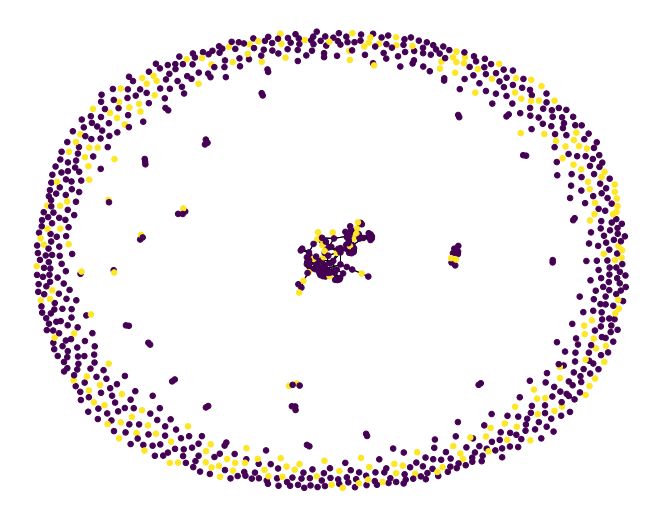

In [ ]:
g, y = convert_to_networkx(graph, n_sample=1000)
plot_graph(g, y)

##train,validation,test set split

In [ ]:
split = T.RandomNodeSplit(num_val=0.1, num_test=0.2)
graph = split(graph)  # resetting data split
print(
    f"train: {int(graph.train_mask.sum())}, ",
    f"val: {int(graph.val_mask.sum())}, ",
    f"test: {int(graph.test_mask.sum())}",
)

train: 26390,  val: 3770,  test: 7540


In [ ]:
print(graph)

Data(x=[37700, 128], edge_index=[2, 578006], y=[37700], train_mask=[37700], val_mask=[37700], test_mask=[37700])


In [ ]:
print(graph.train_mask)

tensor([False,  True,  True,  ...,  True,  True,  True])


In [ ]:
print()

##Multilayer perceptron

In [ ]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
        nn.Linear(dataset.num_node_features, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, 16), 
        nn.ReLU(),
        nn.Linear(16, 2), 

        )

    def forward(self, data):
        x = data.x  # only using node features (x)
        output = self.layers(x)
        return output

We are defining training and evaluation functions with a normal Pytorch train/eval setup.

In [ ]:
def train_node_classifier(model, graph, optimizer, criterion, n_epochs=100):

    for epoch in range(1, n_epochs + 1):
        model.train()
        optimizer.zero_grad()
        out = model(graph)
        loss = criterion(out[graph.train_mask], graph.y[graph.train_mask])
        loss.backward()
        optimizer.step()

        pred = out.argmax(dim=1)
        acc , precision = eval_node_classifier(model, graph, graph.val_mask)

        if epoch % 10 == 0:
            print(f'Epoch: {epoch:03d}, Train Loss: {loss:.3f}, Val Acc: {acc:.3f} , precision : {precision:.3f}')

    return model

from sklearn.metrics import precision_score
def eval_node_classifier(model, graph, mask):

    model.eval()
    pred = model(graph).argmax(dim=1)
    correct = (pred[mask] == graph.y[mask]).sum()
    acc = int(correct) / int(mask.sum())
    precision = precision_score(graph.y[mask], pred[mask])


    return acc , precision

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
graph = graph.to(device)
mlp = MLP().to(device)
optimizer_mlp = torch.optim.Adam(mlp.parameters(), lr=0.1, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

mlp = train_node_classifier(mlp, graph, optimizer_mlp, criterion, n_epochs=150)

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined a

Epoch: 010, Train Loss: 0.479, Val Acc: 0.740 , precision : 0.000


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined a

Epoch: 020, Train Loss: 0.420, Val Acc: 0.844 , precision : 0.748
Epoch: 030, Train Loss: 0.388, Val Acc: 0.852 , precision : 0.778
Epoch: 040, Train Loss: 0.337, Val Acc: 0.852 , precision : 0.806
Epoch: 050, Train Loss: 0.317, Val Acc: 0.851 , precision : 0.784
Epoch: 060, Train Loss: 0.301, Val Acc: 0.847 , precision : 0.736
Epoch: 070, Train Loss: 0.279, Val Acc: 0.842 , precision : 0.747
Epoch: 080, Train Loss: 0.287, Val Acc: 0.846 , precision : 0.763
Epoch: 090, Train Loss: 0.252, Val Acc: 0.843 , precision : 0.743
Epoch: 100, Train Loss: 0.253, Val Acc: 0.840 , precision : 0.713
Epoch: 110, Train Loss: 0.206, Val Acc: 0.830 , precision : 0.684
Epoch: 120, Train Loss: 0.347, Val Acc: 0.856 , precision : 0.831
Epoch: 130, Train Loss: 0.314, Val Acc: 0.855 , precision : 0.804
Epoch: 140, Train Loss: 0.292, Val Acc: 0.856 , precision : 0.810
Epoch: 150, Train Loss: 0.264, Val Acc: 0.850 , precision : 0.784


In [ ]:
test_acc , precision = eval_node_classifier(mlp, graph, graph.test_mask)
print(f'Test Acc: {test_acc:.3f}, precision : {precision:.3f}') 

Test Acc: 0.852, precision : 0.765


##GCN

In [ ]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        output = self.conv2(x, edge_index)

        return output

In [ ]:
gcn = GCN().to(device)
optimizer_gcn = torch.optim.Adam(gcn.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

In [ ]:

gcn = train_node_classifier(gcn, graph, optimizer_gcn, criterion)

Epoch: 010, Train Loss: 0.388, Val Acc: 0.851 , precision : 0.855
Epoch: 020, Train Loss: 0.344, Val Acc: 0.865 , precision : 0.830
Epoch: 030, Train Loss: 0.334, Val Acc: 0.866 , precision : 0.808
Epoch: 040, Train Loss: 0.325, Val Acc: 0.865 , precision : 0.825
Epoch: 050, Train Loss: 0.322, Val Acc: 0.868 , precision : 0.829
Epoch: 060, Train Loss: 0.319, Val Acc: 0.868 , precision : 0.819
Epoch: 070, Train Loss: 0.316, Val Acc: 0.869 , precision : 0.824
Epoch: 080, Train Loss: 0.314, Val Acc: 0.868 , precision : 0.821
Epoch: 090, Train Loss: 0.313, Val Acc: 0.868 , precision : 0.820
Epoch: 100, Train Loss: 0.311, Val Acc: 0.867 , precision : 0.815


In [ ]:
test_acc , precision = eval_node_classifier(gcn, graph, graph.test_mask)
print(f'Test Acc: {test_acc:.3f}, precision : {precision:.3f}')

Test Acc: 0.869, precision : 0.811


In [ ]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 32)
        self.conv2 = GCNConv(32, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        output = self.conv2(x, edge_index)

        return output

In [ ]:
gcn = GCN().to(device)
optimizer_gcn = torch.optim.Adam(gcn.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

In [ ]:
gcn = train_node_classifier(gcn, graph, optimizer_gcn, criterion)

Epoch: 010, Train Loss: 0.352, Val Acc: 0.862
Epoch: 020, Train Loss: 0.334, Val Acc: 0.860
Epoch: 030, Train Loss: 0.322, Val Acc: 0.864
Epoch: 040, Train Loss: 0.317, Val Acc: 0.868
Epoch: 050, Train Loss: 0.313, Val Acc: 0.867
Epoch: 060, Train Loss: 0.310, Val Acc: 0.868
Epoch: 070, Train Loss: 0.308, Val Acc: 0.869
Epoch: 080, Train Loss: 0.306, Val Acc: 0.869
Epoch: 090, Train Loss: 0.303, Val Acc: 0.870
Epoch: 100, Train Loss: 0.301, Val Acc: 0.870
Epoch: 110, Train Loss: 0.298, Val Acc: 0.871
Epoch: 120, Train Loss: 0.296, Val Acc: 0.871
Epoch: 130, Train Loss: 0.294, Val Acc: 0.871
Epoch: 140, Train Loss: 0.292, Val Acc: 0.872
Epoch: 150, Train Loss: 0.289, Val Acc: 0.873
Epoch: 160, Train Loss: 0.287, Val Acc: 0.872
Epoch: 170, Train Loss: 0.285, Val Acc: 0.873
Epoch: 180, Train Loss: 0.283, Val Acc: 0.872
Epoch: 190, Train Loss: 0.282, Val Acc: 0.874
Epoch: 200, Train Loss: 0.280, Val Acc: 0.873


In [ ]:
test_acc , balanced_accurac = eval_node_classifier(gcn, graph, graph.test_mask)
print(f'Test Acc: {test_acc:.3f}, Balanced : {balanced_accurac:.3f}') 


Test Acc: 0.864, Balanced : 0.797


### Visualizing classification result

yellow node: correct 
purple node: wrong


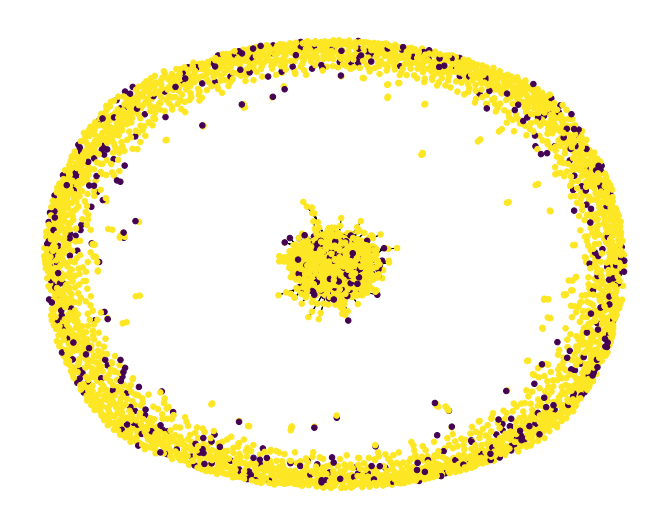

In [ ]:
def visualize_classification_result(model, graph):

    model.eval()
    pred = model(graph).argmax(dim=1)
    corrects = (pred[graph.test_mask] == graph.y[graph.test_mask]).numpy().astype(int)
    test_index = np.arange(len(graph.x))[graph.test_mask.numpy()]
    g, y = convert_to_networkx(graph)
    g_test = g.subgraph(test_index)

    print("yellow node: correct \npurple node: wrong")
    plot_graph(g_test, corrects)

visualize_classification_result(gcn, graph)

##Link Preduction

##Model including encoder and decoder

In [ ]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(
            dim=-1
        )  # product of a pair of nodes on each edge

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()

##Evaluation metric

In [ ]:
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling


def train_link_predictor(
    model, train_data, val_data, optimizer, criterion, n_epochs=100
):

    for epoch in range(1, n_epochs + 1):

        model.train()
        optimizer.zero_grad()
        z = model.encode(train_data.x, train_data.edge_index)

        # sampling training negatives for every training epoch
        neg_edge_index = negative_sampling(
            edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
            num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

        edge_label_index = torch.cat(
            [train_data.edge_label_index, neg_edge_index],
            dim=-1,
        )
        edge_label = torch.cat([
            train_data.edge_label,
            train_data.edge_label.new_zeros(neg_edge_index.size(1))
        ], dim=0)

        out = model.decode(z, edge_label_index).view(-1)
        loss = criterion(out, edge_label)
        loss.backward()
        optimizer.step()

        val_auc = eval_link_predictor(model, val_data)

        if epoch % 10 == 0:
            print(f"Epoch: {epoch:03d}, Train Loss: {loss:.3f}, Val AUC: {val_auc:.3f}")

    return model


@torch.no_grad()
def eval_link_predictor(model, data):

    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()

    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())

##deleting train/val/test mask

In [ ]:


del graph.train_mask 
del graph.val_mask 
del graph.test_mask

##Random split of data

In [ ]:
split = T.RandomLinkSplit(
    num_val=0.05,
    num_test=0.1,
    is_undirected=False,
    add_negative_train_samples=False,
    neg_sampling_ratio=1.0,
)
train_data, val_data, test_data = split(graph)

##Visualizing data

In [ ]:
print('train_data:', train_data)
print('val_data:', val_data)
print('test_data:', test_data)

train_data: Data(x=[37700, 128], edge_index=[2, 491306], y=[37700], edge_label=[491306], edge_label_index=[2, 491306])
val_data: Data(x=[37700, 128], edge_index=[2, 491306], y=[37700], edge_label=[57800], edge_label_index=[2, 57800])
test_data: Data(x=[37700, 128], edge_index=[2, 520206], y=[37700], edge_label=[115600], edge_label_index=[2, 115600])


##Model training

In [ ]:
model = Net(dataset.num_features, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

model = train_link_predictor(model, train_data, val_data, optimizer, criterion)

Epoch: 010, Train Loss: 0.495, Val AUC: 0.948
Epoch: 020, Train Loss: 0.462, Val AUC: 0.946
Epoch: 030, Train Loss: 0.445, Val AUC: 0.951
Epoch: 040, Train Loss: 0.437, Val AUC: 0.953
Epoch: 050, Train Loss: 0.432, Val AUC: 0.955
Epoch: 060, Train Loss: 0.428, Val AUC: 0.956
Epoch: 070, Train Loss: 0.425, Val AUC: 0.957
Epoch: 080, Train Loss: 0.423, Val AUC: 0.957
Epoch: 090, Train Loss: 0.422, Val AUC: 0.958
Epoch: 100, Train Loss: 0.422, Val AUC: 0.955


##Model testing

In [ ]:
test_auc = eval_link_predictor(model, test_data)
print(f"Test: {test_auc:.3f}")

Test: 0.955
